# Laplace approximation ( Quadratic approximation) 

In this notebook we will approximate posterior of beta-bernouli model for coin toss problem using laplace approximation method

author: @karm-patel @nipunbatra

In [1]:
try:
    from probml_utils import latexify, savefig
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig

import jax
import jax.numpy as jnp
from jax import lax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    import optax
except ModuleNotFoundError:
    %pip install -qqq optax
    import optax

try:
    from rich import print
except ModuleNotFoundError:
    %pip install -qqq rich
    from rich import print

try:
    from tqdm import trange
except:
    %pip install -qqq tqdm
    from tqdm import trange


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
dist = tfp.distributions

import os

In [2]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

In [3]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]

In [4]:
# prior distribution ~ Beta
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


# likelihood distribution ~ Bernoulli
def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

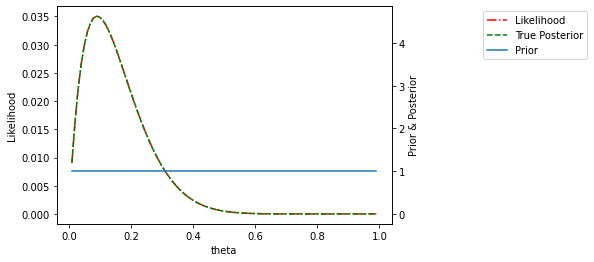

In [5]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

ax = plt.gca()
ax2 = ax.twinx()
(plt2,) = ax2.plot(theta_range, exact_posterior.prob(theta_range), "g--", label="True Posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

## Laplace approximation from scratch in JAX

As mentioned in book2 section 7.4.3, Using laplace approximation, any distribution can be approximated as normal distribution having mean $\hat{\theta}$ and standard deviation as $H^{-1}$
\begin{align}
  H = \triangledown ^2_{\theta = \hat{\theta}} \log p(\theta|\mathcal{D}) \\
  p(\theta|\mathcal{D}) = \frac{1}{Z}p(\theta|\mathcal{D}) = \mathcal{N}(\theta |\hat{\theta}, H^{-1})
\end{align}
Where H is Hessian and $\hat{\theta}$ is the mode

### Find $\hat{\theta}$

No we find $\hat{\theta}$ ($\theta$_map) by minimizing negative log prior-likelhihood. 

In [6]:
def neg_log_prior_likelihood_fn(params, dataset):
    theta = params["theta"]
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()  # log probability of likelihood
    prior_log_prob = prior_dist().log_prob(theta)  # log probability of prior
    return -(likelihood_log_prob + prior_log_prob)  # negative log_prior_liklihood

In [7]:
loss_and_grad_fn = jax.value_and_grad(neg_log_prior_likelihood_fn)
params = {"theta": 0.5}
neg_joint_log_prob, grads = loss_and_grad_fn(params, dataset)

optimizer = optax.adam(0.01)
opt_state = optimizer.init(params)

In [8]:
@jax.jit
def train_step(carry, data_output):

    params = carry["params"]
    neg_joint_log_prob, grads = loss_and_grad_fn(params, dataset)

    opt_state = carry["opt_state"]
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    carry = {"params": params, "opt_state": opt_state}
    data_output = {"params": params, "loss": neg_joint_log_prob}

    return carry, data_output

In [9]:
carry = {"params": params, "opt_state": opt_state}
data_output = {"params": params, "loss": neg_joint_log_prob}

n = 100
iterator = jnp.ones(n)
last_carry, output = jax.lax.scan(train_step, carry, iterator)

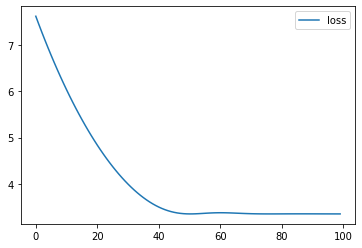

In [10]:
loss = output["loss"]
plt.plot(loss, label="loss")
plt.legend();

In [11]:
optimized_params = last_carry["params"]
theta_map = optimized_params["theta"]
print(f"theta_map = {theta_map}")

theta_map = 0.09168018400669098

### loc and scale of approximated normal posterior

In [12]:
loc = theta_map  # loc of approximate posterior
print(f"loc = {loc}")

loc = 0.09168018400669098

In [13]:
# scale of approximate posterior
scale = 1 / jnp.sqrt(jax.hessian(neg_log_prior_likelihood_fn)(optimized_params, dataset)["theta"]["theta"])
print(f"scale = {scale}")

scale = 0.08733917027711868

### True posterior and laplace approximated posterior

In [14]:
latexify(fig_width=0.45 * 6, fig_height=1.5)  # to apply latexify, set LATEXIFY=1 in environment variable

saving image to figures/bb_laplace_latexified.pdf
Figure size: [2.7 1.5]


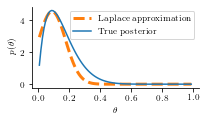

In [15]:
plt.figure()
y = jnp.exp(dist.Normal(loc, scale).log_prob(theta_range))
plt.plot(theta_range, y, label="Laplace approximation", color="tab:orange", linestyle="--", lw=3)
plt.plot(theta_range, exact_posterior.prob(theta_range), label="True posterior", color="tab:blue")
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta)$")
sns.despine()
plt.legend()
savefig("bb_laplace")  # set FIG_DIR =  "path/to/figure" enviornment variable to save figure

# Grid Approximation

In [16]:
n_points_grid = 20
theta_range = jnp.linspace(0.01, 0.99, n_points_grid)

In [17]:
likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)

In [18]:
unnormalized_post = prior_dist().prob(theta_range) * likelihood
grid_appx = (unnormalized_post / unnormalized_post.sum()) * n_points_grid  # Done so that the area under curve sums to 1

In [19]:
len(grid_appx)

20

saving image to figures/bb_grid_latexified.pdf
Figure size: [2.7 1.5]


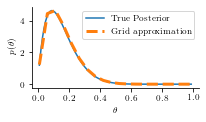

In [20]:
plt.figure()
plt.plot(jnp.linspace(0.01, 0.99, 100), exact_posterior.prob(jnp.linspace(0.01, 0.99, 100)), label="True Posterior")
plt.plot(theta_range, grid_appx, label="Grid approximation", linestyle="--", lw=3)

plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta)$")
sns.despine()
savefig("bb_grid")